In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from stargazer.stargazer import Stargazer
from linearmodels.iv import IV2SLS
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats

In [2]:
data = pd.read_stata('africa.dta')
data.head()

,x,y,group,xc,yc,center,distance,part,cap,income
0,65.247635,68.470764,1.0,60.993904,71.246994,25.0,5.079537,15.686678,92.124344,135.682449
1,17.112789,55.649460,3.0,17.800810,51.957294,40.0,3.755725,12.932481,138.966156,140.656082
2,53.541748,19.327223,3.0,48.068378,19.055309,42.0,5.480121,14.311936,88.882370,146.201965
3,64.877892,33.090942,1.0,65.107460,32.802567,7.0,0.368594,19.091896,91.726250,167.282196
4,67.073807,64.514954,1.0,60.993904,71.246994,25.0,9.071142,15.176675,71.116608,149.815842


**1. Data preparation**

In [3]:
summary = data.describe()
summary

,x,y,group,xc,yc,center,distance,part,cap,income
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,48.529327,48.443504,2.029500,49.004665,47.647854,26.943501,7.342320,11.447350,102.324600,137.250000
std,27.861746,24.511271,0.818513,28.319460,23.931879,14.484354,3.531068,4.191597,24.985056,18.774225
min,0.153942,0.006010,1.000000,0.884082,2.240541,1.000000,0.203446,0.000000,19.197878,57.170677
25%,21.766729,28.263509,1.000000,26.015562,25.541374,13.000000,4.681370,8.776036,86.046284,125.027357
50%,51.351805,50.708405,2.000000,50.649651,51.957294,31.000000,7.153416,11.856450,102.832863,137.018074
75%,72.799995,65.635342,3.000000,78.337456,63.367405,40.000000,9.624988,14.204031,119.080307,150.063194
max,106.602692,99.999565,3.000000,99.887405,99.397995,50.000000,23.262558,22.950117,177.980835,204.630173


In [4]:
variables = ['x', 'y', 'group', 'xc', 'yc', 'center', 'distance', 'part', 'cap', 'income']

missing_values = data[variables].isnull().sum()
print("Missing values for each variable:")
print(missing_values)

Q1 = data[variables].quantile(0.25)
Q3 = data[variables].quantile(0.75)
IQR = Q3 - Q1

outliers = ((data[variables] < (Q1 - 1.5 * IQR)) | (data[variables] > (Q3 + 1.5 * IQR))).sum()
print("\nOutliers for each variable:")
print(outliers)

Missing values for each variable:
x           0
y           0
group       0
xc          0
yc          0
center      0
distance    0
part        0
cap         0
income      0
dtype: int64

Outliers for each variable:
x            0
y            0
group        0
xc           0
yc           0
center       0
distance    12
part        24
cap         18
income      13
dtype: int64


There are no missing values in the data. There are however some outliers which are inspected below.

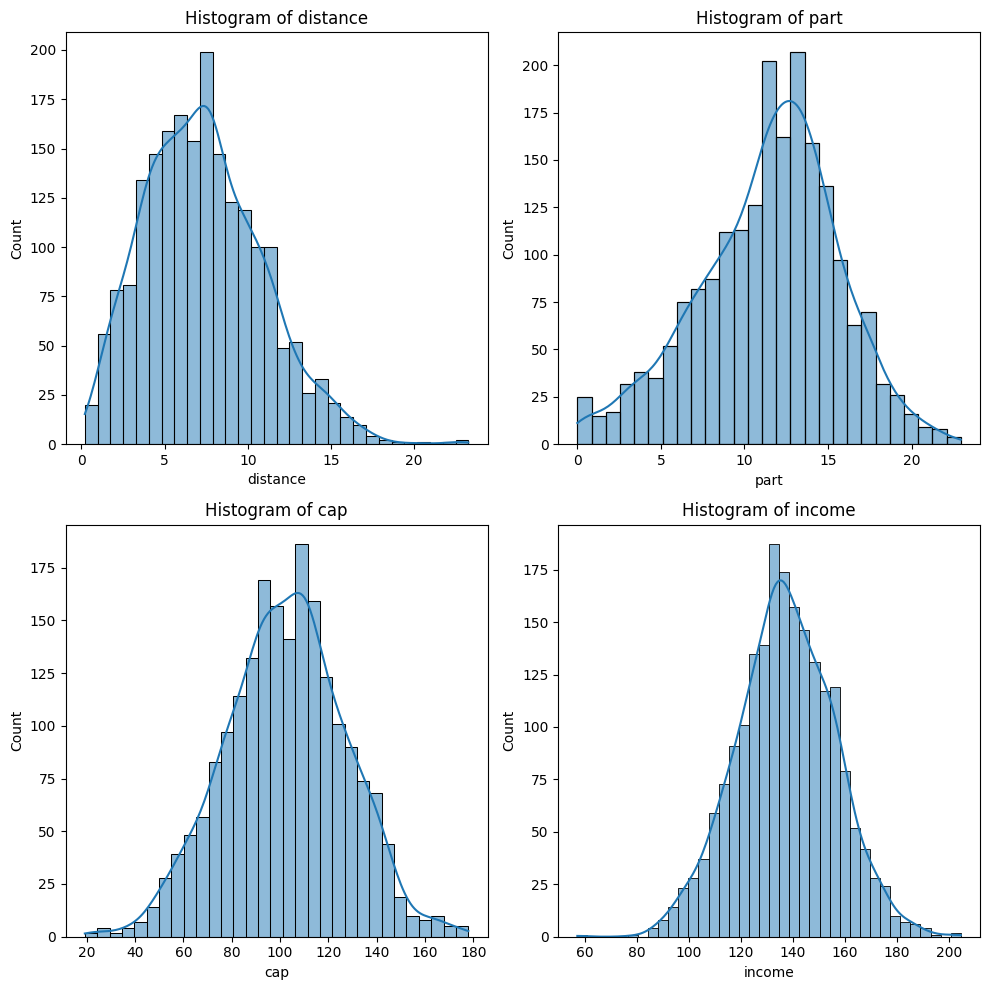

In [5]:
variables = ['distance', 'part', 'cap', 'income']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for var, ax in zip(variables, axs.flatten()):
    sns.histplot(data[var], kde=True, ax=ax)
    ax.set_title('Histogram of ' + var)

plt.tight_layout()
plt.show()

The histograms show the distribution of the variables with outliers. The distributions look pretty normal and there don't seem to be any extreme outliers.

**2. Regressions (individuals)**

In [8]:
dependent = data['income']
X = sm.add_constant(data['part'])

model = sm.OLS(dependent, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     464.9
Date:                Tue, 19 Dec 2023   Prob (F-statistic):           7.21e-93
Time:                        19:17:21   Log-Likelihood:                -8493.2
No. Observations:                2000   AIC:                         1.699e+04
Df Residuals:                    1998   BIC:                         1.700e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        114.9743      1.100    104.502      0.000     112.817     117.132
part           1.9459      0.090     21.561      0.000       1.769       2.123
==============================================================================
Omnibus:                        0.361   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.835   Jarque-Bera (JB):                0.293
Skew:                          -0.019   Prob(JB):                        0.864
Kurtosis:                       3.045   Cond. No.                         35.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

A straightforward linear regression implies that increasing the participation by 1 increases income by around 1.946 euros. It is however possible that the variable participation is correlated with the error term. For example, if motivation is correlated with participation, and motivation is correlated with income, then the error term is correlated with participation. To solve this problem, we can use an instrumental variable:

First, we check whether the instrument is strong.

In [18]:
X = sm.add_constant(data['distance'])
y = data['part']

model = sm.OLS(y, X)
results = model.fit()
print(f'F-statistic: {results.fvalue:.2f}')

F-statistic: 932.66


The F-statistic is well above 10, so the instrument is strong.

In [88]:
dependent = data['income']
endog = data['part']
exog = pd.DataFrame(np.ones(len(data)), columns=['Intercept'])
instrument = data['distance']

iv = IV2SLS(dependent, exog, endog, instrument)
results = iv.fit()

results.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                 income   R-squared:                      0.0725
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0720
No. Observations:                2000   F-statistic:                    5.8548
Date:                Tue, Dec 19 2023   P-value (F-stat)                0.0155
Time:                        10:29:18   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      132.46     2.0203     65.563     0.0000      128.50      136.41
part           0.4189     0.1731     2.4197     0.0155      0.0796      0.7581
==============================================================================

Endogenous: part
Instruments: distance
Robust Covariance (Heteroskedastic)
Debiased: False
"""

**3. Map of houses and community centers**

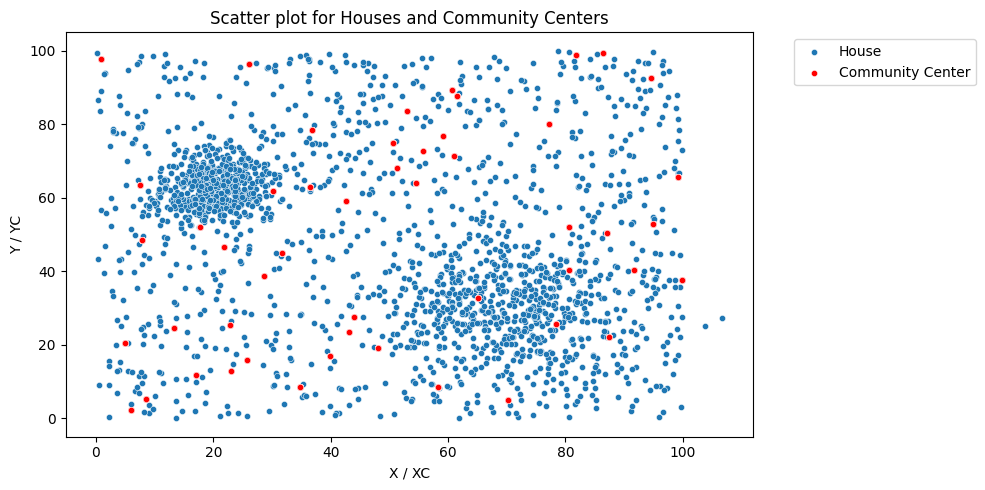

In [89]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.scatterplot(x='x', y='y', data=data, ax=ax, s=20, label='House')

sns.scatterplot(x='xc', y='yc', data=data, ax=ax, color='red', s=20, label='Community Center')

ax.set_title('Scatter plot for Houses and Community Centers')
ax.set_xlabel('X / XC')
ax.set_ylabel('Y / YC')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

The scatterplot shows houses and community centers distributed seemingly at random. This randomness supports the exclusion restriction in our IV regression, as it suggests that the distance to community centers (our instrument) likely affects income (dependent variable) primarily through its influence on participation in community activities (endogenous variable), rather than having a direct effect on income.

**4. Instrumental variable regression (households)**

In [90]:
data_means = data.groupby('center')[['income', 'part', 'distance']].mean().reset_index()
data_means.columns = ['center', 'mean_income', 'mean_part', 'mean_dist']

data = pd.merge(data, data_means, on='center', how='left')

data

,x,y,group,xc,yc,center,distance,part,cap,income,mean_income,mean_part,mean_dist
0,65.247635,68.470764,1.0,60.993904,71.246994,25.0,5.079537,15.686678,92.124344,135.682449,145.051498,14.844684,6.689123
1,17.112789,55.649460,3.0,17.800810,51.957294,40.0,3.755725,12.932481,138.966156,140.656082,133.873657,9.626195,6.493014
2,53.541748,19.327223,3.0,48.068378,19.055309,42.0,5.480121,14.311936,88.882370,146.201965,134.714706,11.382967,6.852208
3,64.877892,33.090942,1.0,65.107460,32.802567,7.0,0.368594,19.091896,91.726250,167.282196,142.964828,13.589553,7.237815
4,67.073807,64.514954,1.0,60.993904,71.246994,25.0,9.071142,15.176675,71.116608,149.815842,145.051498,14.844684,6.689123
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,17.723021,28.441809,3.0,13.377138,24.468124,32.0,5.888706,13.340007,122.478485,127.514351,138.483704,12.441358,6.229427
1996,63.326031,35.020229,2.0,65.107460,32.802567,7.0,2.844559,13.197288,111.977600,125.312035,142.964828,13.589553,7.237815
1997,23.242783,32.175903,3.0,22.766520,25.325298,24.0,6.867140,11.282405,60.621052,108.963234,132.044388,11.318337,6.167306
1998,16.669905,78.950928,3.0,7.424784,63.367405,41.0,18.119560,0.452368,83.069824,105.777130,125.242798,6.633493,9.246074


In [91]:
dependent = data['mean_income']
exog = pd.DataFrame(np.ones(len(data)), columns=['Intercept'])
endog = data['mean_part']
instrument = data['mean_dist']

iv = IV2SLS(dependent, exog, endog, instrument)
results = iv.fit()

results.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:            mean_income   R-squared:                      0.9028
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9027
No. Observations:                2000   F-statistic:                    3353.4
Date:                Tue, Dec 19 2023   P-value (F-stat)                0.0000
Time:                        10:29:18   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      107.09     0.4910     218.09     0.0000      106.13      108.05
mean_part      2.6348     0.0455     57.908     0.0000      2.5456      2.7239
==============================================================================

Endogenous: mean_part
Instruments: mean_dist
Robust Covariance (Heteroskedastic)
Debiased: False
"""

The difference in the coefficients between individuals and communities could be attributed to the collective benefits of participation. For an individual, increased participation in community activities might lead to a smaller increase in income, as the time spent volunteering could otherwise be used for income-generating work. However, when viewed from a community perspective, the scenario changes. The efforts of those who volunteer can create benefits that extend to the entire community. Even those who do not directly participate can reap the rewards of a more vibrant, cooperative, and resource-rich community. Thus, the overall impact on community income could be greater for each unit increase in participation, explaining the higher coefficient at the community level.

**5. Differences in participation across ethnic groups**

First, we have to check whether the assumptions of the ANOVA test are met. We assume that the observations are independent. Secondly, we check for normality. We do this by creating a Q-Q plot. If the data points in this plot fall along a 45-degree angle line, it suggests that the data is normally distributed. Lastly, we check the assumption of homogeneity of variance. We use Levene’s test for this. If the p-value from Levene’s test is greater than 0.05, it suggests that the variances are equal across our groups.

Levene's Test: LeveneResult(statistic=32.42294111497868, pvalue=1.3889362972392843e-14)


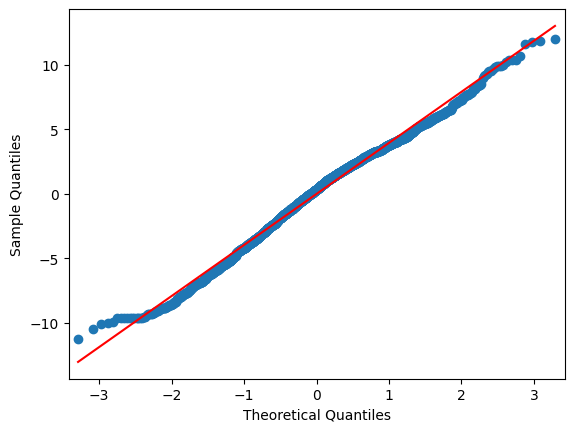

In [40]:
model = ols('part ~ C(group)', data=data).fit()

levene_test = stats.levene(data['part'][data['group'] == 1],
                            data['part'][data['group'] == 2],
                            data['part'][data['group'] == 3])
print(f"Levene's Test: {levene_test}")

res = model.resid 
fig = sm.qqplot(res, line='s')
plt.show()

The normality assumption is met, but the variance assumption is not. We can use the Kruskal-Wallis H-test instead as it is a non-parametric method.

In [31]:
groups = data.groupby('group')['part'].apply(list)

H, p = stats.kruskal(*groups)

print(f'Kruskal-Wallis H-test result: H={H:.4f}, p={p:.4f}')

Kruskal-Wallis H-test result: H=185.1248, p=0.0000


The p-value is basically zero which implies that the groups' participation rates are not equal. Let's see this in more detail:

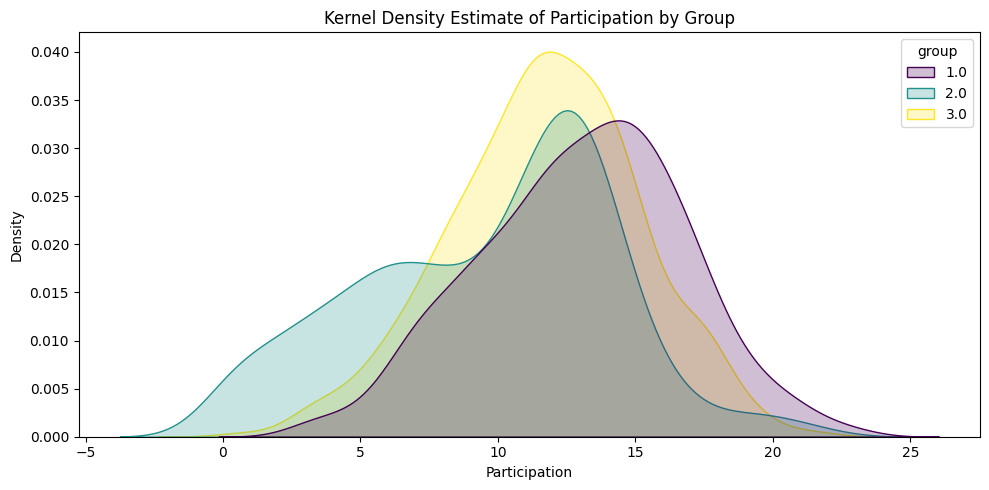

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.kdeplot(data=data, x='part', hue='group', ax=ax, palette="viridis", fill=True)

ax.set_title('Kernel Density Estimate of Participation by Group')
ax.set_xlabel('Participation')
ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

The above picture indeed suggests that the participation differs between groups. The kernel density estimates for the different groups are quite different from each other. It seems like group 1 has the highest participation rate. The peaks of group 2 and 3 are quite similar. The KDE of group 3 is approximately normal, while the KDE of group 2 has quite a large area under the curve on the left side of the peak. This suggests that group 2 has a lower participation rate than group 3.